In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

In [2]:
import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
DataPath = '/kaggle/input/lgg-mri-segmentation/kaggle_3m/'


dirs = []
images = []
masks = []
for dirname, _, filenames in os.walk(DataPath):
    for filename in filenames:
        if 'mask'in filename:
            dirs.append(dirname.replace(DataPath, ''))
            masks.append(filename)
            images.append(filename.replace('_mask', ''))

In [4]:
print(masks[:10],images[:10])

['TCGA_DU_7010_19860307_56_mask.tif', 'TCGA_DU_7010_19860307_8_mask.tif', 'TCGA_DU_7010_19860307_34_mask.tif', 'TCGA_DU_7010_19860307_33_mask.tif', 'TCGA_DU_7010_19860307_43_mask.tif', 'TCGA_DU_7010_19860307_39_mask.tif', 'TCGA_DU_7010_19860307_7_mask.tif', 'TCGA_DU_7010_19860307_31_mask.tif', 'TCGA_DU_7010_19860307_6_mask.tif', 'TCGA_DU_7010_19860307_38_mask.tif'] ['TCGA_DU_7010_19860307_56.tif', 'TCGA_DU_7010_19860307_8.tif', 'TCGA_DU_7010_19860307_34.tif', 'TCGA_DU_7010_19860307_33.tif', 'TCGA_DU_7010_19860307_43.tif', 'TCGA_DU_7010_19860307_39.tif', 'TCGA_DU_7010_19860307_7.tif', 'TCGA_DU_7010_19860307_31.tif', 'TCGA_DU_7010_19860307_6.tif', 'TCGA_DU_7010_19860307_38.tif']


In [5]:
imagePath_df = pd.DataFrame({'directory':dirs, 'images':images,'masks':masks})
imagePath_df.head(9)

,directory,images,masks
0,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_56.tif,TCGA_DU_7010_19860307_56_mask.tif
1,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_8.tif,TCGA_DU_7010_19860307_8_mask.tif
2,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_34.tif,TCGA_DU_7010_19860307_34_mask.tif
3,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_33.tif,TCGA_DU_7010_19860307_33_mask.tif
4,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_43.tif,TCGA_DU_7010_19860307_43_mask.tif
5,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_39.tif,TCGA_DU_7010_19860307_39_mask.tif
6,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_7.tif,TCGA_DU_7010_19860307_7_mask.tif
7,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_31.tif,TCGA_DU_7010_19860307_31_mask.tif
8,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_6.tif,TCGA_DU_7010_19860307_6_mask.tif


In [6]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [7]:
def UNET(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [8]:
ImgHeight = 256
ImgWidth = 256
input_img = Input((ImgHeight,ImgWidth,3), name='img')
model = UNET(input_img, n_filters=16, dropout=0.2, batchnorm=True)

2022-04-07 09:45:47.833671: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [9]:
len(imagePath_df['directory'])

3929

## Load Model

In [10]:
import keras
from keras.models import load_model
model.load_weights('../input/modelbrainmri/MODEL/model-brain-mri.h5')

In [11]:
def get_confusion_matrix_intersection_mats(mask, bpred):
    """ Returns dict of 4 boolean numpy arrays with True at TP, FP, FN, TN
    """
    intersection = np.sum(np.logical_and(mask,bpred))

    union = np.sum(np.logical_or(mask,bpred))
    smooth = .1
    mask_sum = (np.sum(np.abs(mask)) + np.sum(np.abs(bpred)))

    print(mask_sum)
    iou = (intersection + smooth) / (union + smooth)
    dice = 2 * ((intersection + smooth)/(mask_sum + smooth))

    iou = np.mean(iou)
    dice = np.mean(dice)
    iou = round(iou,2)
    dice = round(dice,2)
    
    confusion_matrix_arrs = {}

    mask_inverse = np.logical_not(mask)
    predicted_inverse = np.logical_not(bpred)

    confusion_matrix_arrs['tp'] = np.logical_and(mask, bpred)
    confusion_matrix_arrs['tn'] = np.logical_and(mask_inverse, predicted_inverse)
    confusion_matrix_arrs['fp'] = np.logical_and(mask_inverse, bpred)
    confusion_matrix_arrs['fn'] = np.logical_and(mask, predicted_inverse)
    
    #     print("Confusion Matrix:",a)
    TP = np.sum(confusion_matrix_arrs['tp']==True)
    TN = np.sum(confusion_matrix_arrs['tn']==True)
    FN = np.sum(confusion_matrix_arrs['fp']==True)
    FP = np.sum(confusion_matrix_arrs['fn']==True)
    
    acc = ((TP+TN)/(TP+TN+FN+FP))
    pre = ((TP)/(TP+FP))
    
    acc =round(acc,2)
    pre = round(pre,2)
    
    return acc,pre,iou,dice
# iou,dice

## Plots

In [12]:
import random
import cv2
import matplotlib.pyplot as plt

def plots():
    plt.figure(figsize=(12,12))
    plt.subplot(1,4,1)
    plt.imshow(np.squeeze(img),cmap = plt.cm.gray)
    plt.title('Original Image')
    plt.subplot(1,4,2)
    plt.imshow(mask)
    plt.title('Original Mask')
    plt.subplot(1,4,3)
    plt.imshow(np.squeeze(pred), cmap = plt.cm.gray)
    plt.title('Prediction')
    plt.subplot(1,4,4)
    plt.imshow(bpred,cmap = plt.cm.gray)
    plt.title('BinaryPrediction')
    plt.show()
    print("Pred Shape :",np.squeeze(pred).shape )
    
def prints():
    print("Mask Shape :",mask.shape )
    print("Pred after squeeze Shape :",pred.shape)
    print("Mask After rgb2gray Shape :",mask.shape )
    

In [13]:
#     print("Mask Values:", mask )
#     0-1
#     print("Pred Values:", pred )
#    probabilities
Iou = np.array([], dtype=np.float64)
Dice = np.array([], dtype=np.float64)
index = np.array([], dtype=np.int)
accuracy = np.array([], dtype=np.float64)
precision = np.array([], dtype=np.float64)

for i in range(800):
    
    idx = random.randint(0,len(imagePath_df['directory']))
    index=np.append(index,idx)
    imagePath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['images'].iloc[idx])
    maskPath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['masks'].iloc[idx])
    

    
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    img = cv2.resize(image,(ImgHeight,ImgWidth))
    img = img/255
    img = img[np.newaxis,:,:,:]
#     print("Image Shape :",img.shape )
    
    """The first dimension is the batch size. If you are feeding 1 image at a time you can simply make the first dimension 1 and 
    it doesn't change your data any, just changes the indexing to 4"""
    pred = model.predict(img)
    
#     pred = np.asarray(pred)
    bpred = np.array(np.squeeze(pred) > 0.5,dtype = np.uint8)
    
#     Visualize images
#     plots()

    mask = np.asarray(mask) #(1,256, 256, 3)
    mask = np.squeeze(np.squeeze(mask))#(256, 256, 3)\
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask=mask/255
    
    pred = np.squeeze(pred)
    bpred = np.asarray(bpred) #(256, 256)
    #Make a binary prediction     
    pred = cv2.normalize(pred, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)    
    #     pred = cv2.cvtColor(pred, cv2.COLOR_BGR2GRAY)
#     plots()

# METRICS
# PHANTOM ME GNWSTH MASKA DIKH MOY!!!!!
    (acc,pre,iou,dice) = get_confusion_matrix_intersection_mats(mask, bpred)

    accuracy = np.append(accuracy,acc)
    precision = np.append(precision,pre)
    Iou = np.append(Iou, iou)
    Dice = np.append(Dice,dice)

#     prints()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys
2022-04-07 09:45:49.310672: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


7276.0
0.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in long_scalars


0.0
1527.0
5052.0
293.0
751.0
44.0
7879.0
7537.0
1568.0
6551.0
214.0
0.0
8556.0
2771.0
0.0
0.0
0.0
1284.0
0.0
0.0
0.0
5149.0
0.0
4708.0
1862.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2718.0
7014.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
111.0
0.0
8428.0
0.0
0.0
0.0
8042.0
0.0
8088.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
50.0
0.0
0.0
0.0
0.0
1729.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
418.0
0.0
0.0
0.0
0.0
0.0
0.0
517.0
0.0
1177.0
0.0
419.0
0.0
0.0
0.0
0.0
4437.0
0.0
0.0
7524.0
8698.0
5610.0
0.0
0.0
9098.0
2566.0
1649.0
8428.0
0.0
804.0
0.0
7400.0
0.0
0.0
37.0
1775.0
2897.0
0.0
0.0
1638.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
55.0
0.0
0.0
7240.0
0.0
0.0
5676.0
0.0
0.0
133.0
2474.0
0.0
499.0
46.0
0.0
0.0
0.0
398.0
0.0
4920.0
0.0
0.0
0.0
0.0
4246.0
5365.0
151.0
1632.0
4708.0
0.0
1528.0
4382.0
0.0
5178.0
0.0
0.0
0.0
0.0
110.0
0.0
0.0
0.0
0.0
98.0
2223.0
4614.0
0.0
283.0
0.0
0.0
314.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2485.0
11450.0
0.0
0.0
5766.0
560.0
1498.0
735.0
0.0
2198.0
0.0
3958.0
2726.0
0.0
2944.0

In [14]:
df = pd.DataFrame({'Jacard':Iou, 'Dice_Coef':Dice, 'Accuracy':accuracy, 'Precision':precision})
df = df.dropna()
indice = df[(df['Jacard']==0)].index
df.drop(indice, inplace=True)
print("Jacard Mean: {m}. Jacard STD: {s}.".format(m = round(df['Jacard'].mean(),2) ,s = round(df['Jacard'].std(),2)))
print("Dice_Coef Mean: {m}. Dice_Coef STD: {s}.".format(m = round(df['Dice_Coef'].mean(),2),s = round(df['Dice_Coef'].std(),2)))
print("Accuracy Mean: {m}. Accuracy STD: {s}.".format(m = round(df['Accuracy'].mean(),2),s = round(df['Accuracy'].std(),2)))
print("Precision Mean: {m}. Precision STD: {s}.".format(m = round(df['Precision'].mean(),2),s = round(df['Precision'].std(),2)))


# sthlh (1-MASKA) / (0-OXI MASKA) +++ PLHROFORIA APO DATA.CSV +++
# df.to_csv("metric-results_v2.csv",index=False)
df

Jacard Mean: 0.69. Jacard STD: 0.22.
Dice_Coef Mean: 0.79. Dice_Coef STD: 0.2.
Accuracy Mean: 0.99. Accuracy STD: 0.01.
Precision Mean: 0.79. Precision STD: 0.24.


,Jacard,Dice_Coef,Accuracy,Precision
0,0.89,0.94,0.99,0.97
3,0.54,0.70,0.99,0.87
4,0.66,0.79,0.98,0.66
8,0.77,0.87,0.98,0.78
9,0.85,0.92,0.99,0.93
...,...,...,...,...
791,0.89,0.94,1.00,0.97
793,0.81,0.90,1.00,0.89
794,0.67,0.80,0.99,0.67
795,0.47,0.64,0.99,0.56


(256, 256, 3) (256, 256) (256, 256) (256, 256)
uint8 float64 float32 uint8
0


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 256 BarContainer objects>)

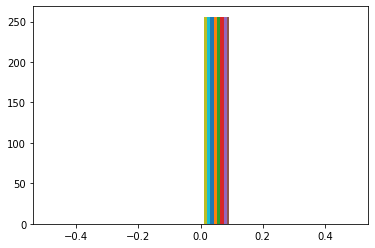

In [15]:
# Investigate the low dice coef 

print(image.shape,mask.shape, pred.shape, bpred.shape)
print(image.dtype,mask.dtype, pred.dtype, bpred.dtype)
print(np.sum(mask==255))
# print(np.sum(bpred==0.9))
mask=mask/255
c=np.round(mask-bpred)
plt.hist(c)

## Boxplots

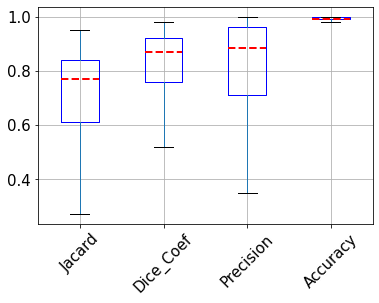

In [16]:
# Plot boxplot
boxprops = dict(linestyle='-', color='blue')
medianprops = dict(linestyle= '--',linewidth='2', color='r')
fig,ax  = plt.subplots()

boxplot = df.boxplot(column=['Jacard','Dice_Coef','Precision', 'Accuracy'],rot=45, fontsize=15,
                    medianprops=medianprops, boxprops=boxprops,showfliers=False, showmeans=False)
plt.show()



In [17]:
image=[]
masks=[]
for idx in index:
#     print(idx)
    
    imagePath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['images'].iloc[idx])
    image.append(imagePath)
    maskPath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['masks'].iloc[idx])
    masks.append(maskPath)

df = pd.DataFrame({'images':image,'masks':masks})
# print(df['images'][790])
# print(df['masks'][790])

# df = pd.DataFrame({'image':image,'mask':mask})
df

,images,masks
0,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
...,...,...
795,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
796,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
797,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
798,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


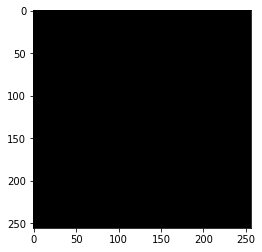

In [18]:
# bpred = bpred.astype(int)
plt.imshow(bpred,cmap = plt.cm.gray)

(256, 256, 3)
Number of pixels : 0
Number of TP: 58001.666666666664
(256, 256, 3)
Number of pixels : 103511
Number of TP: 34581.333333333336
(256, 256, 3)
Number of pixels : 249774
Number of TP: 57840.666666666664
(256, 256, 3)
Number of pixels : 0
Number of TP: 60957.0
(256, 256, 3)
Number of pixels : 0
Number of TP: 65044.0
(256, 256, 3)
Number of pixels : 32270
Number of TP: 54435.666666666664
(256, 256, 3)
Number of pixels : 0
Number of TP: 48444.666666666664
(256, 256, 3)
Number of pixels : 0
Number of TP: 51568.666666666664
(256, 256, 3)
Number of pixels : 32818
Number of TP: 57880.333333333336
(256, 256, 3)
Number of pixels : 0
Number of TP: 51353.0


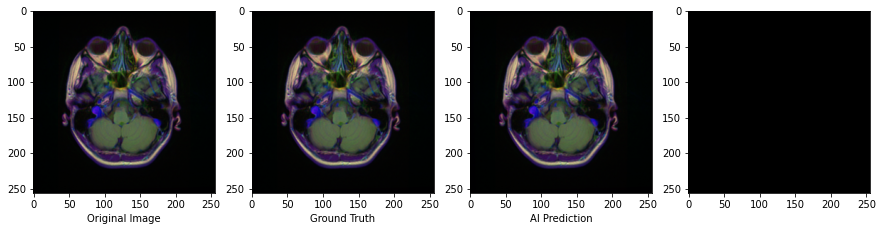

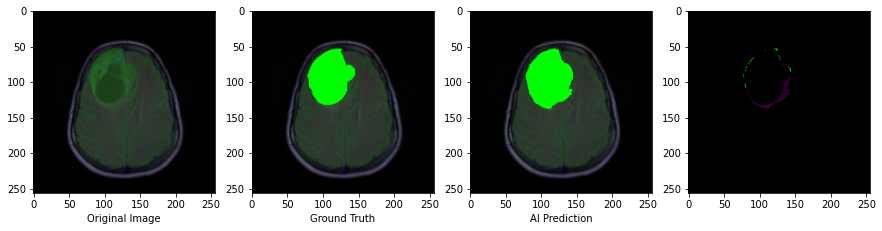

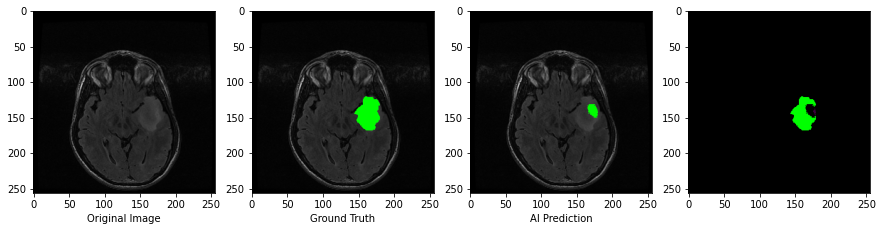

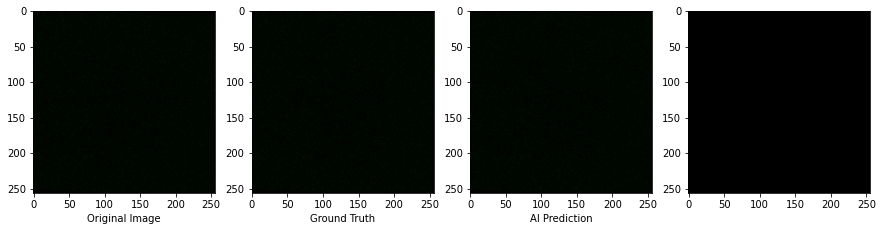

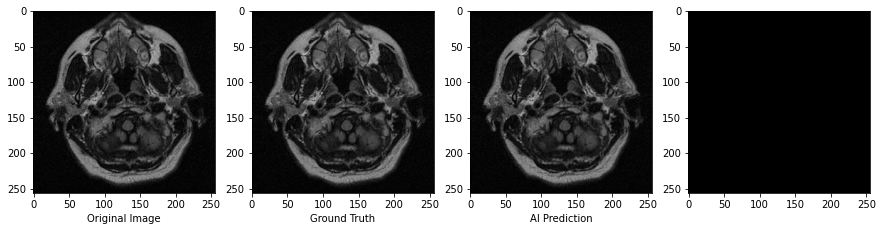

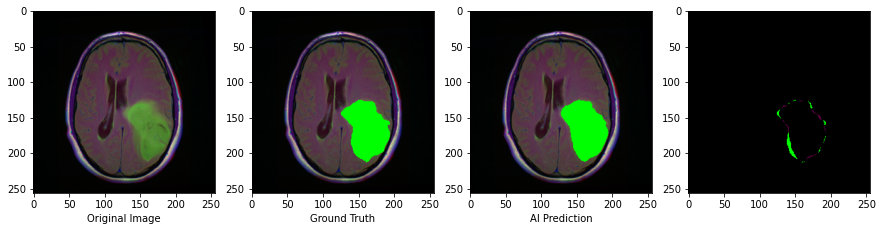

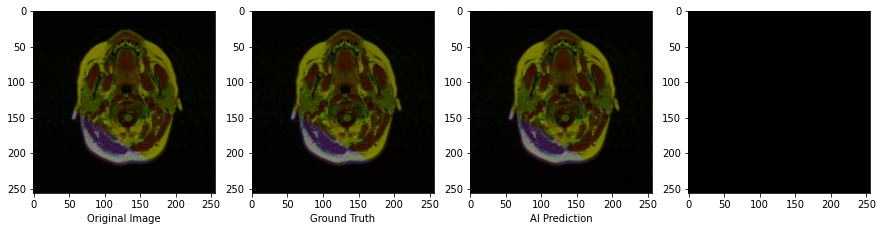

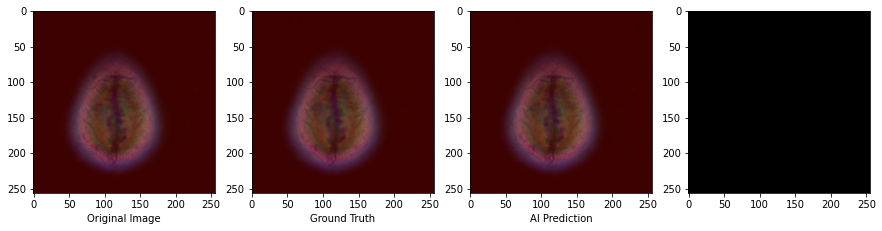

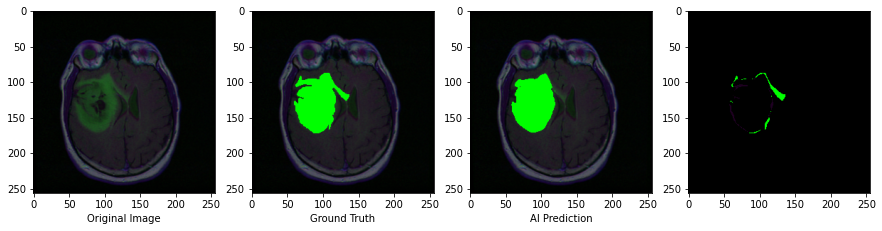

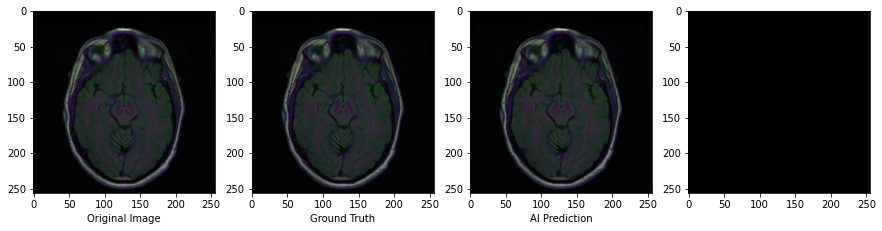

In [19]:

for i in range(10):
    
    """Run it before run the above code . Else not working"""
    index = random.randint(0,len(imagePath_df))
    imagePath = os.path.join(DataPath, imagePath_df['directory'].iloc[index], imagePath_df['images'].iloc[index])
    maskPath = os.path.join(DataPath, imagePath_df['directory'].iloc[index], imagePath_df['masks'].iloc[index])
    
    
    img = cv2.imread(imagePath)
    print(img.shape)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    img = cv2.resize(img ,(ImgHeight,ImgWidth))
    img = img / 255
    img = img[np.newaxis, :, :, :]
   
    pred=model.predict(img)
    img = np.squeeze(img)
    
    #Plot Original MRI Scans
    original = img.copy()
    fig, ax = plt.subplots(1,4,figsize = (15,5))
    ax[0].imshow(original,cmap = plt.cm.gray)
    ax[0].set_xlabel('Original Image')
    
    #Plot MRI Scans with their masks
    main = original.copy()
    label = cv2.imread(maskPath)
    sample = np.array(np.squeeze(label), dtype = np.uint8)
    
    contours, hier = cv2.findContours(sample[:,:,0],cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    sample_over_gt = cv2.drawContours(main, contours, -1,[0,255,0], thickness=-1)
    ax[1].imshow(sample_over_gt,cmap = plt.cm.gray)
    ax[1].set_xlabel('Ground Truth')
    
    #Plot MRI Predicted Masks
    main = original.copy()
    sample = np.array(np.squeeze(pred) > 0.5, dtype = np.uint8)
    
    contours, hier = cv2.findContours(sample,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    sample_over_pr = cv2.drawContours(main, contours, -1, [0,255,0], thickness=-1)
    ax[2].imshow(sample_over_pr, cmap = plt.cm.gray)
    ax[2].set_xlabel("AI Prediction")
    
#     #Plot Difference : MRI Mask - MRI UNET Prediciton
#     #FN
    diff = sample_over_gt - sample_over_pr
    ax[3].imshow(diff)
    ax[3].set_xlabel(print("Number of pixels :",round(abs(diff.sum()))))
    
#     #TP
#      tn, fp, fn, tp = get_confusion_matrix_elements(sample_over_gt,sample_over_pr)
    intersection = np.logical_and(sample_over_gt,sample_over_pr)
    print("Number of TP:",(np.sum(intersection>0.5)/3))
#     image_shape = 256*256
#     print("Number of Total pixels:", image_shape)
    


plt.show()

In [20]:
np.logical_and(sample_over_gt,sample_over_pr)


array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False,